In [1]:
! python3 -m pip install --upgrade pip
! python3 -m pip install --upgrade SpeechRecognition
! python3 -m pip install --upgrade pydub
! python3 -m pip install --upgrade sklearn
! python3 -m pip install --upgrade pylangacq

     |████████████████████████████████| 1.5 MB 19.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 32.8 MB 15.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=b3ef5930dae08c802e08fcc68a5b608dfde49d162632863c5726d3eca20f3c34
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
     |████████████████████████████████| 66 kB 6.9 MB/s  eta 0:00:01


In [2]:
import IPython.display as ipd
import librosa
import librosa.display
import kapre
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import io
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pydub.silence import split_on_silence 

# Cloud storage
# from google.cloud import storage

# .cha file reader
import pylangacq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Transcribe audio data to txt data

In [ ]:
# !ls '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/'

In [ ]:
# initialize the speech recognizer
r = sr.Recognizer()

# a function that splits the audio file into chunks 
# and applies speech recognition 
def silence_based_conversion(path, wav_file): 
    text_df = pd.DataFrame()
  
    # open the audio file stored in 
    # the local system as a wav file. 
    song = AudioSegment.from_wav(path + wav_file) 
    print(song)
  
    # open a file where we will concatenate   
    # and store the recognized text 
    text_file = wav_file.partition('.')[0] + ".txt"
    text_file_dir = path + "output_text/" 
    if not os.path.exists(text_file_dir):
        os.makedirs(text_file_dir)    
    text_file_path = text_file_dir + text_file
    fh = open(text_file_path, "w+") 
          

    dBFS = song.dBFS
    print('dBFS: ' + str(dBFS))
    # chunks = split_on_silence(song, 
    #     min_silence_len = 500,
    #     silence_thresh = dBFS-16,
    #     keep_silence = 250 
    # )

    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(song, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 250, 
  
        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = dBFS - 16
        # keep_silence = 250
    ) 
    # setting minimum length of each chunk to 25 seconds
    target_length = 20 * 1000 
    output_chunks = [chunks[0]]
    for chunk in chunks[1:]:
      print('Length of chunk: ' + str(len(output_chunks[-1])) )
      if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
      else:
        # if the last output chunk is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)    
    # print(chunks)
  
    # create a directory to store the audio chunks. 
    try: 
        os.mkdir(path + 'audio_chunks') 
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    os.chdir(path +'audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in output_chunks: 
              
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 10) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        text_file_id = text_file.partition('.')[0]
        chunk_file_name = text_file_id + "_" + "chunk" + str(i) + ".wav"
        print("saving " + chunk_file_name) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("./" + chunk_file_name, bitrate ='192k', format ="wav") 
  
        # the name of the newly created chunk 
        filename = chunk_file_name
  
        print("Processing chunk file: " + filename) 
  
        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 
  
        # create a speech recognition object 
        r = sr.Recognizer() 
  
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            #r.adjust_for_ambient_noise(source) 
            audio_listened = r.record(source) 
  
        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 
            text_df = text_df.append({'ID': text_file_id, 'Text': rec}, ignore_index = True)
  
        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 
  
        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 
  
        i += 1
    return text_df

# silence_based_conversion(audio_path_cc, 'S001.wav')        
# text_df = silence_based_conversion(audio_path_cd, 'S079.wav')        
# print(text_df)
# silence_based_conversion(audio_path_cc + 'spkr0.wav')        

## Read csv data file with ID, TEXT and MMSE scores to be used for training and validation

In [ ]:
!ls /tf/data/

In [3]:
data_path = '/tf'

transcription_combination_txt_file_path = data_path + "/data/" + "transcription_combination_id_txt_mmse.csv"
filtered_merged_data = pd.read_csv(transcription_combination_txt_file_path)
filtered_merged_data.head()

,Unnamed: 0,ID,Age,Gender,TEXT,MMSE,Group
0,0,S001,74,male,well there's a mother standing there washing ...,30,cc
1,1,S001,74,male,he's standing up there in the cupboard taking...,30,cc
2,2,S001,74,male,and outside the window there's a curved walk ...,30,cc
3,3,S001,74,male,and the window's open . the kids are somewher...,30,cc
4,4,S001,74,male,and there are two cups and a saucer on the si...,30,cc


# BERT Transfer Learning

In [4]:
gpus = tf.config.list_physical_devices('GPU')

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [7]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 722 kB 56.7 MB/s eta 0:00:01
     |████████████████████████████████| 862 kB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 57.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 42.6 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.44-py3-none-any.whl size=886084 sha256=b49ae608acb8f776ecad724dcb25e722136e128f47f249d0b504f771e500f0a8
  Stored in directory: /root/.cache/pip/wheels/d4/6d/ad/81106f259084ee9e99156f754f8a4957e4c2cb9c1ccf866f8a
Successfully built sacremoses


In [8]:
from transformers import BertTokenizer
bert_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_name,
                                          add_special_tokens=True,
                                          do_lower_case=True,
                                          max_length=256,
                                          pad_to_max_length=True)


In [9]:
def bert_encoder(input_text):
    # txt = input_text.numpy().decode('utf-8')
    txt = input_text
    encoded = tokenizer.encode_plus(txt, add_special_tokens=True, 
                                    max_length=256, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True,
                                    truncation=True)
    return encoded['input_ids'], encoded['token_type_ids'], \
           encoded['attention_mask']

In [10]:
meta_smile = pd.read_csv('meta_eGeMAPSv01b.csv')
meta_smile['ID'] = [x[0:4] for x in meta_smile['ID']]
meta_smile.head()

,Unnamed: 0,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
0,0,0,S001,74,male,30,cc,train,26.871142,cc
1,1,1,S002,62,female,30,cc,train,26.556385,cc
2,2,2,S003,69,female,29,cc,train,25.519604,cc
3,3,3,S004,71,female,30,cc,train,27.771522,cc
4,4,4,S005,74,female,30,cc,train,26.533502,cc


In [11]:
split = pd.merge(filtered_merged_data, meta_smile[['ID', 'split']], on = ['ID'], how = 'left') 

In [12]:
split.head()

,Unnamed: 0,ID,Age,Gender,TEXT,MMSE,Group,split
0,0,S001,74,male,well there's a mother standing there washing ...,30,cc,train
1,1,S001,74,male,he's standing up there in the cupboard taking...,30,cc,train
2,2,S001,74,male,and outside the window there's a curved walk ...,30,cc,train
3,3,S001,74,male,and the window's open . the kids are somewher...,30,cc,train
4,4,S001,74,male,and there are two cups and a saucer on the si...,30,cc,train


In [13]:
bert_train = [bert_encoder(r) for r in filtered_merged_data["TEXT"]]
bert_lbl = filtered_merged_data["MMSE"]
bert_train = np.array(bert_train)
# bert_lbl = tf.keras.utils.to_categorical(bert_lbl)

In [14]:
x_train = bert_train[split['split'] == 'train']
x_test = bert_train[split['split'] == 'test']
x_val = bert_train[split['split'] == 'val']

y_train = bert_lbl[split['split'] == 'train']
y_test = bert_lbl[split['split'] == 'test']
y_val = bert_lbl[split['split'] == 'val']

In [15]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(966, 3, 256) (966,)
(219, 3, 256) (219,)
(215, 3, 256) (215,)


In [16]:
tr_reviews, tr_segments, tr_masks = np.split(x_train, 3, axis=1)
val_reviews, val_segments, val_masks = np.split(x_val, 3, axis=1)
test_reviews, test_segments, test_masks = np.split(x_test, 3, axis=1)

tr_reviews = tr_reviews.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()
val_reviews = val_reviews.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()
test_reviews = test_reviews.squeeze()
test_segments = test_segments.squeeze()
test_masks = test_masks.squeeze()

In [17]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y


In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((tr_reviews, tr_masks, tr_segments, y_train)).\
            map(example_to_features).shuffle(100).batch(64)
valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews,val_masks, val_segments, y_val)).\
            map(example_to_features).shuffle(100).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_reviews,test_masks, test_segments, y_test)).\
            map(example_to_features).shuffle(100).batch(64)

In [19]:
train_ds

<BatchDataset shapes: ({input_ids: (None, 256), attention_mask: (None, 256), token_type_ids: (None, 256)}, (None,)), types: ({input_ids: tf.int64, attention_mask: tf.int64, token_type_ids: tf.int64}, tf.int64)>

In [107]:
# from transformers import TFBertForSequenceClassification
# bert_model = TFBertForSequenceClassification.from_pretrained(bert_name, num_labels=31)

In [97]:
# # optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="sparse_categorical_crossentropy")
# # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# # metrics = tf.metrics.CategoricalCrossentropy()
# # bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
# bert_model.compile(optimizer = optimizer, 
#                    loss=tf.keras.metrics.mean_squared_error,
#                    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [98]:
# print("Fine-tuning BERT on Training data")
# bert_history = bert_model.fit(train_ds, epochs=25, 
#                               validation_data=valid_ds)

In [50]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
#     dropout = Dropout(0.25, name='dropout_1')(cls_token)
    out = Dense(1, activation='relu', kernel_initializer='he_normal')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    model = Model(inputs=input_word_ids, outputs=out)
    for layer in model.layers[:-1]:
      layer.trainable = False
    # model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    # optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer = optimizer, 
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [51]:
import transformers
MAX_LEN = 256
# with strategy.scope():
def create_model():
  transformer_layer = (
      transformers.TFAutoModelWithLMHead.from_pretrained(bert_name)
  )
  model = build_model(transformer_layer, max_len=MAX_LEN)
  return model


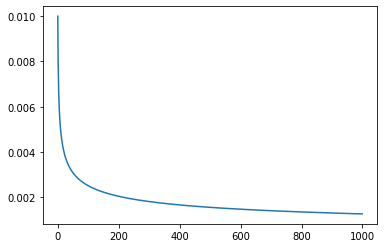

In [52]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.3)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=0.01))

scheduler = SquareRootScheduler(lr=0.01)
plt.plot(tf.range(1000), [scheduler(t) for t in range(1000)])

In [53]:
model = create_model()
model.summary()

checkpoint_path = "/tf/saved_model/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss', 
                                                 patience=50, 
                                                 restore_best_weights=True,
                                                 verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    restore_best_weights=True)

print("Fine-tuning BERT on Training data")
bert_history = model.fit(train_ds, 
                         epochs=100, 
                         validation_data=valid_ds,
                         callbacks=[cp_callback, es_callback])

- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
tf_bert_for_masked_lm_7 (TFB ((None, 256, 30522),)     110104890 
_________________________________________________________________
tf.__operators__.getitem_7 ( (None, 30522)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 30523     
Total params: 110,135,413
Trainable params: 30,523
Non-trainable params: 110,104,890
_________________________________________________________________
Fine-tuning BERT on Training data
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask', 'token_type_ids'] which did not match any model input. They will be ignored by the model.


16/16 [==============================] - 25s 721ms/step - loss: 513.5513 - rmse: 22.5161 - val_loss: 271.3319 - val_rmse: 16.4722

Epoch 00001: val_loss improved from inf to 271.33191, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 2/100
16/16 [==============================] - 8s 521ms/step - loss: 287.1390 - rmse: 16.9296 - val_loss: 245.6773 - val_rmse: 15.6741

Epoch 00002: val_loss improved from 271.33191 to 245.67726, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 3/100
16/16 [==============================] - 8s 520ms/step - loss: 235.3720 - rmse: 15.3250 - val_loss: 135.3697 - val_rmse: 11.6349

Epoch 00003: val_loss improved from 245.67726 to 135.36974, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 4/100
16/16 [==============================] - 8s 520ms/step - loss: 151.2048 - rmse: 12.2561 - val_loss: 92.2451 - val_rmse: 9.6044

Epoch 00004: val_loss improved from 135.36974 to 92.24511, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoc

16/16 [==============================] - 8s 521ms/step - loss: 47.6800 - rmse: 6.9033 - val_loss: 82.3049 - val_rmse: 9.0722

Epoch 00039: val_loss did not improve from 80.59245
Epoch 40/100
16/16 [==============================] - 8s 522ms/step - loss: 49.0910 - rmse: 7.0041 - val_loss: 80.5486 - val_rmse: 8.9749

Epoch 00040: val_loss improved from 80.59245 to 80.54864, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 41/100
16/16 [==============================] - 8s 521ms/step - loss: 46.0536 - rmse: 6.7852 - val_loss: 81.5258 - val_rmse: 9.0292

Epoch 00041: val_loss did not improve from 80.54864
Epoch 42/100
16/16 [==============================] - 9s 545ms/step - loss: 44.4500 - rmse: 6.6651 - val_loss: 80.0209 - val_rmse: 8.9454

Epoch 00042: val_loss improved from 80.54864 to 80.02094, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 43/100
16/16 [==============================] - 8s 521ms/step - loss: 44.5087 - rmse: 6.6695 - val_loss: 81.9092 - val_rmse: 9.

16/16 [==============================] - 8s 522ms/step - loss: 46.8781 - rmse: 6.8449 - val_loss: 73.4465 - val_rmse: 8.5701

Epoch 00079: val_loss improved from 73.83196 to 73.44646, saving model to /tf/saved_model/checkpoints/cp.ckpt
Epoch 80/100
16/16 [==============================] - 8s 520ms/step - loss: 40.5036 - rmse: 6.3623 - val_loss: 75.6475 - val_rmse: 8.6976

Epoch 00080: val_loss did not improve from 73.44646
Epoch 81/100
16/16 [==============================] - 8s 522ms/step - loss: 42.7337 - rmse: 6.5341 - val_loss: 75.4849 - val_rmse: 8.6882

Epoch 00081: val_loss did not improve from 73.44646
Epoch 82/100
16/16 [==============================] - 8s 522ms/step - loss: 41.3155 - rmse: 6.4264 - val_loss: 75.5223 - val_rmse: 8.6904

Epoch 00082: val_loss did not improve from 73.44646
Epoch 83/100
16/16 [==============================] - 8s 521ms/step - loss: 41.3075 - rmse: 6.4258 - val_loss: 76.3885 - val_rmse: 8.7400

Epoch 00083: val_loss did not improve from 73.44646


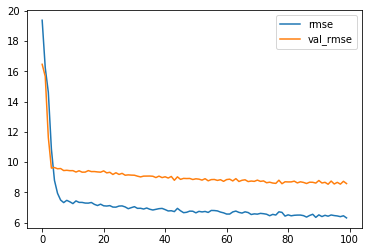

In [54]:
metrics = bert_history.history
plt.plot(bert_history.epoch, metrics['rmse'], metrics['val_rmse'])
plt.legend(['rmse', 'val_rmse'])
# axes = plt.axes()
# axes.set_ylim([2, 10])
plt.show()

# Evaluation and prediction based on BERT model

In [70]:
model_reload = create_model()
model_reload.load_weights(checkpoint_path)
model_reload.summary()

- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
tf_bert_for_masked_lm_8 (TFB ((None, 256, 30522),)     110104890 
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 30522)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 30523     
Total params: 110,135,413
Trainable params: 30,523
Non-trainable params: 110,104,890
_________________________________________________________________


In [72]:
print("Evaluate on vale data")
results = model.evaluate(val_reviews, y_val, batch_size=64)
print("val rmse:", np.sqrt(results)[0])

Evaluate on vale data
4/4 [==============================] - 1s 332ms/step - loss: 73.6281 - rmse: 8.5807
val rmse: 8.580681202840784


In [73]:
print("Evaluate on train data")
results = model.evaluate(tr_reviews, y_train, batch_size=64)
print("train rmse:", np.sqrt(results)[0])

Evaluate on train data
16/16 [==============================] - 6s 382ms/step - loss: 33.9569 - rmse: 5.8273
train rmse: 5.827256697947955


In [74]:
print("Evaluate on test data")
results = model.evaluate(test_reviews, y_test, batch_size=64)
print("test rmse:", np.sqrt(results)[0])

Evaluate on test data
4/4 [==============================] - 1s 326ms/step - loss: 42.7405 - rmse: 6.5376
test rmse: 6.537622290902546


In [59]:
transcription_txt_file_path = data_path + "/data/" + "transcription_original_id_txt_mmse.csv"
filtered_merged_data = pd.read_csv(transcription_txt_file_path)
filtered_merged_data.head()

,Unnamed: 0,ID,Age,Gender,TEXT,MMSE,Group
0,0,S001,74,male,well there's a mother standing there washing ...,30,cc
1,1,S002,62,female,somebody's getting cookies out_of the cookie ...,30,cc
2,2,S003,69,female,okay . there's a little boy and he's standing...,29,cc
3,3,S004,71,female,are you ready ? well the sink is overflowing ...,30,cc
4,4,S005,74,female,okay . the mother's washing the dishes and th...,30,cc


In [60]:
bert_train = [bert_encoder(r) for r in filtered_merged_data["TEXT"]]
bert_lbl = filtered_merged_data["MMSE"]
bert_train = np.array(bert_train)

In [69]:
checkpoint_path

'/tf/saved_model/checkpoints/cp.ckpt'

In [75]:
sc_reviews, sc_segments, sc_masks = np.split(bert_train, 3, axis=1)
predict = model_reload.predict(sc_reviews.squeeze(), batch_size=64)
filtered_merged_data['predict'] = [x[0] if x[0] <= 30 else 30 for x in predict]
filtered_merged_data.head()

,Unnamed: 0,ID,Age,Gender,TEXT,MMSE,Group,predict
0,0,S001,74,male,well there's a mother standing there washing ...,30,cc,26.000910
1,1,S002,62,female,somebody's getting cookies out_of the cookie ...,30,cc,28.357574
2,2,S003,69,female,okay . there's a little boy and he's standing...,29,cc,25.372913
3,3,S004,71,female,are you ready ? well the sink is overflowing ...,30,cc,23.448502
4,4,S005,74,female,okay . the mother's washing the dishes and th...,30,cc,26.735813


In [76]:
from sklearn.metrics import  mean_squared_error
np.sqrt(mean_squared_error(filtered_merged_data['MMSE'], filtered_merged_data['predict']))

6.375482706226624

In [77]:
pd.merge(filtered_merged_data, meta_smile[['ID', 'split']], on = ['ID'], how = 'left').\
    to_csv(path_or_buf = 'meta_bert.csv', index=True)

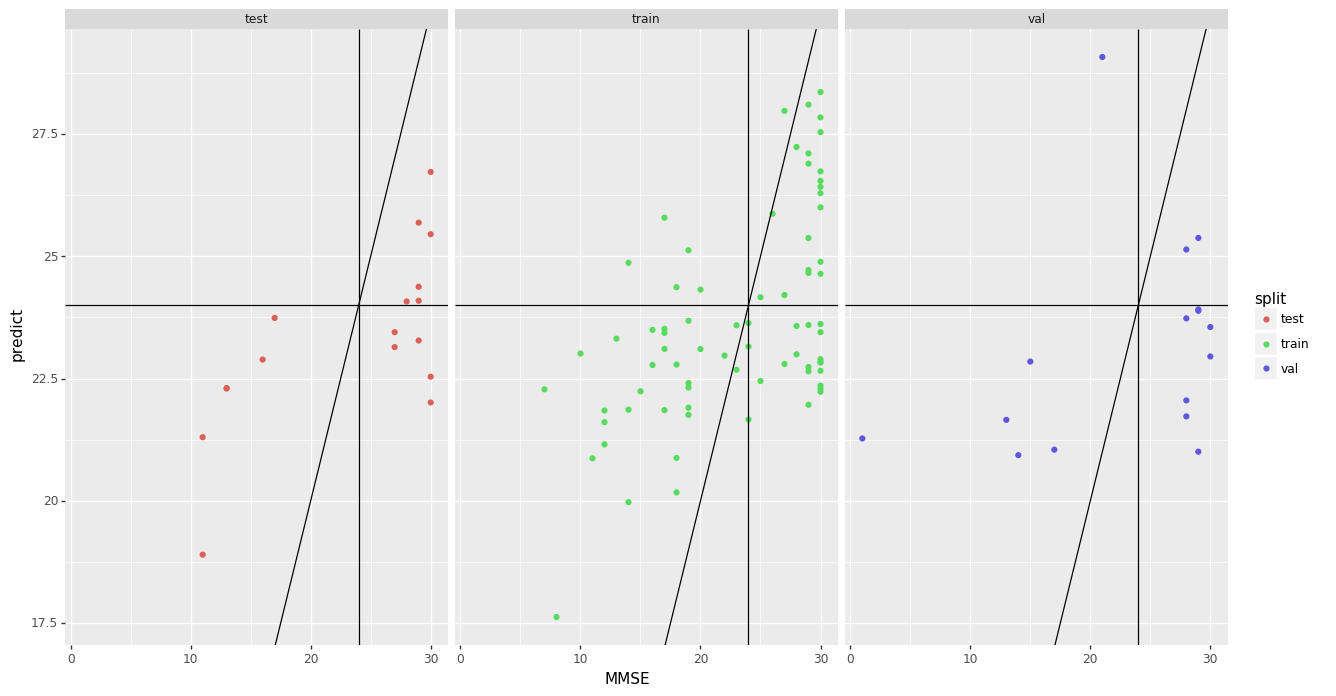

<ggplot: (8777619853860)>

In [78]:
ggplot(pd.merge(filtered_merged_data, meta_smile[['ID', 'split']], on = ['ID'], how = 'left')) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))